In [1]:
!python generate_data.py

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
from functools import reduce
from utils.regression_models import strong_regression_model_factory, weak_regression_model_factory
from utils.tools import load_obj, summarize_posterior, summarize_ppc

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext blackcellmagic

%load_ext autoreload
%autoreload 2

# Strong Priors

In [3]:
model_data = load_obj('data/regression_bootstrap_data')

yobs = model_data['Yobs']
subject_ids = model_data['subject_ids']
y = model_data['y_est']
times = model_data['times']

with strong_regression_model_factory(yobs, times, subject_ids):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    strong_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, s_ka, z_ka, betas_ka, alpha, s_ke, z_ke, betas_ke, log_ke, s_CL, z_CL, betas_CL, log_CL]
100%|██████████| 4000/4000 [00:06<00:00, 634.01it/s]


In [4]:
df = pd.DataFrame({'yobs':yobs,
                   'y':y,
                   'times':times,
                   'subject_ids':subject_ids})

predictions = summarize_posterior(strong_data, 'y_est', 'pred')
ppc = summarize_ppc(strong_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

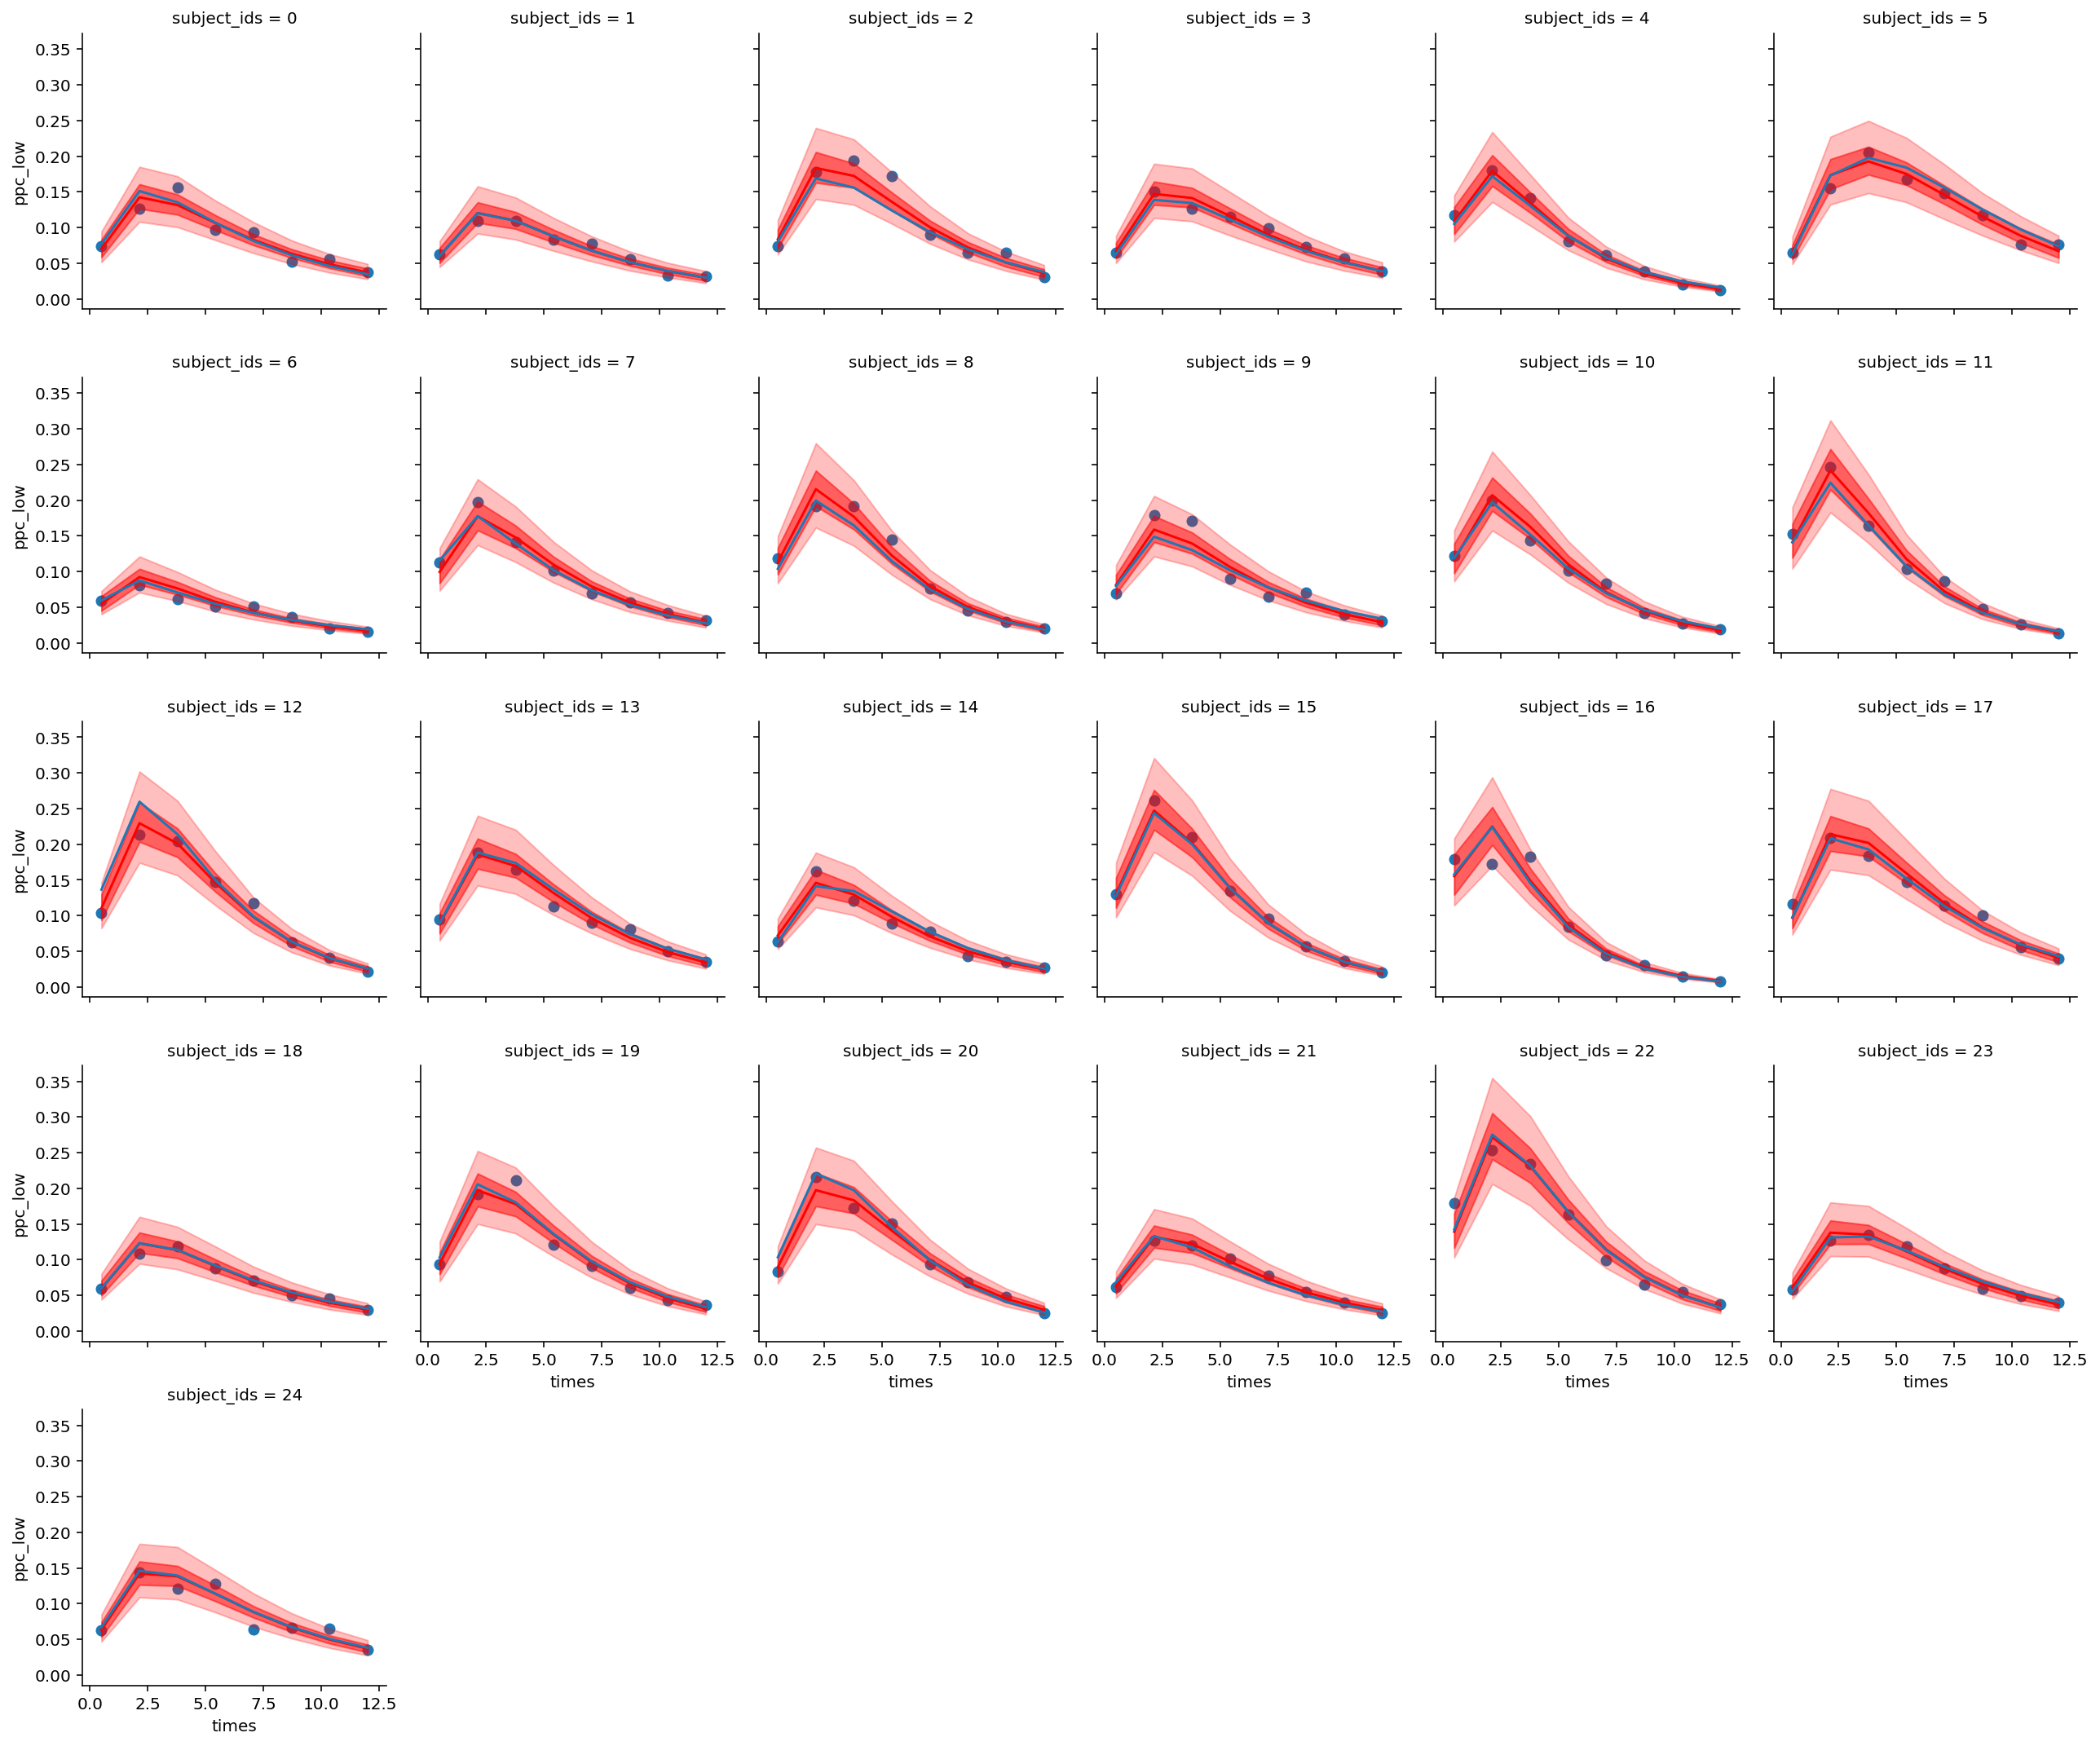

In [5]:
g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'red')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'red')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'red')

# Weak Priors

In [6]:
with weak_regression_model_factory(yobs, times, subject_ids):
    prior_predictive = pm.sample_prior_predictive(1000)
    trace = pm.sample(draws = 1000, tune = 1000, chains = 4, random_seed = 19920908)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    weak_data = az.from_pymc3(prior=prior_predictive, trace=trace, posterior_predictive=posterior_predictive)
    
predictions = summarize_posterior(weak_data, 'y_est', 'pred')
ppc = summarize_ppc(weak_data,'Yobs','ppc')

dfpred = df.join(predictions).join(ppc)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, s_ka, z_ka, betas_ka, alpha, s_ke, z_ke, betas_ke, log_ke, s_CL, z_CL, betas_CL, log_CL]
100%|██████████| 4000/4000 [00:06<00:00, 626.97it/s]


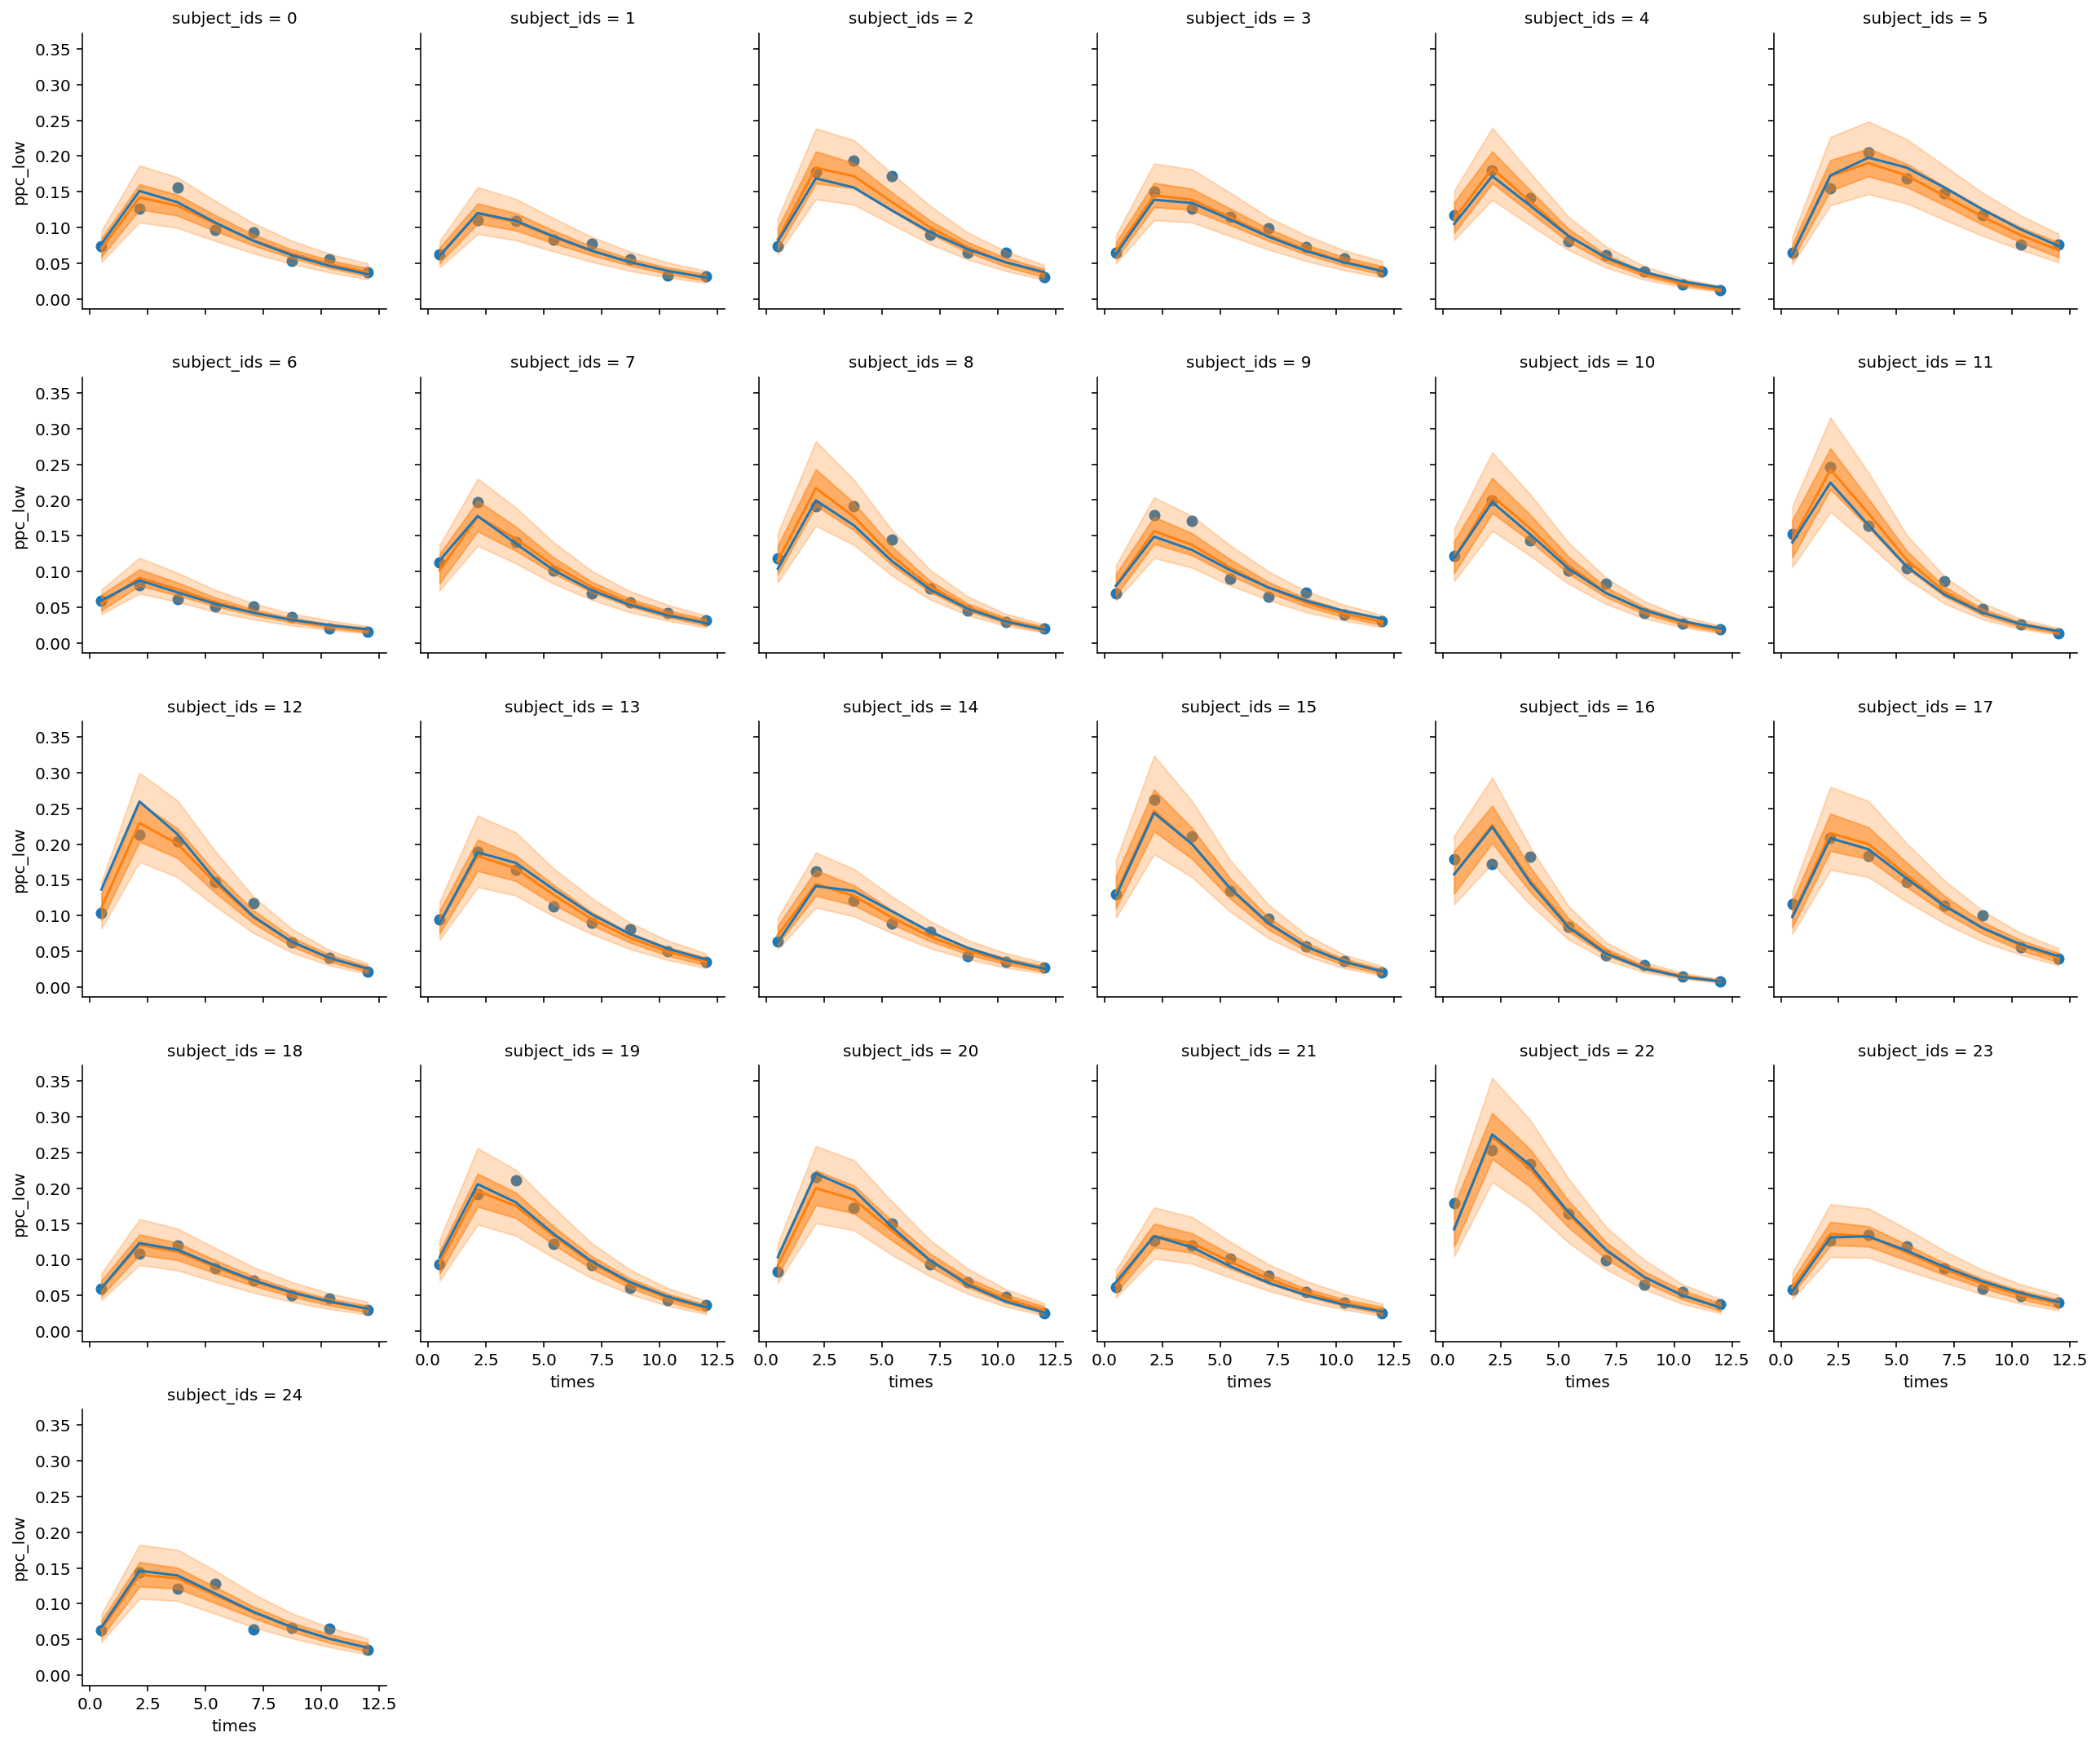

In [7]:
g = sns.FacetGrid(data = dfpred.query('subject_ids<=25'), col='subject_ids', col_wrap=6)

g.map(plt.scatter, 'times','yobs', color = 'C0')
g.map(plt.plot, 'times','pred_pred', color = 'C1')
g.map(plt.plot, 'times','y', color = 'C0')
g.map(plt.fill_between,'times','pred_low','pred_high',alpha = 0.5, color = 'C1')
g.map(plt.fill_between,'times','ppc_low','ppc_high',alpha = 0.25, color = 'C1')

(<Figure size 432x3240 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2447f6d0>],
       dtype=object))

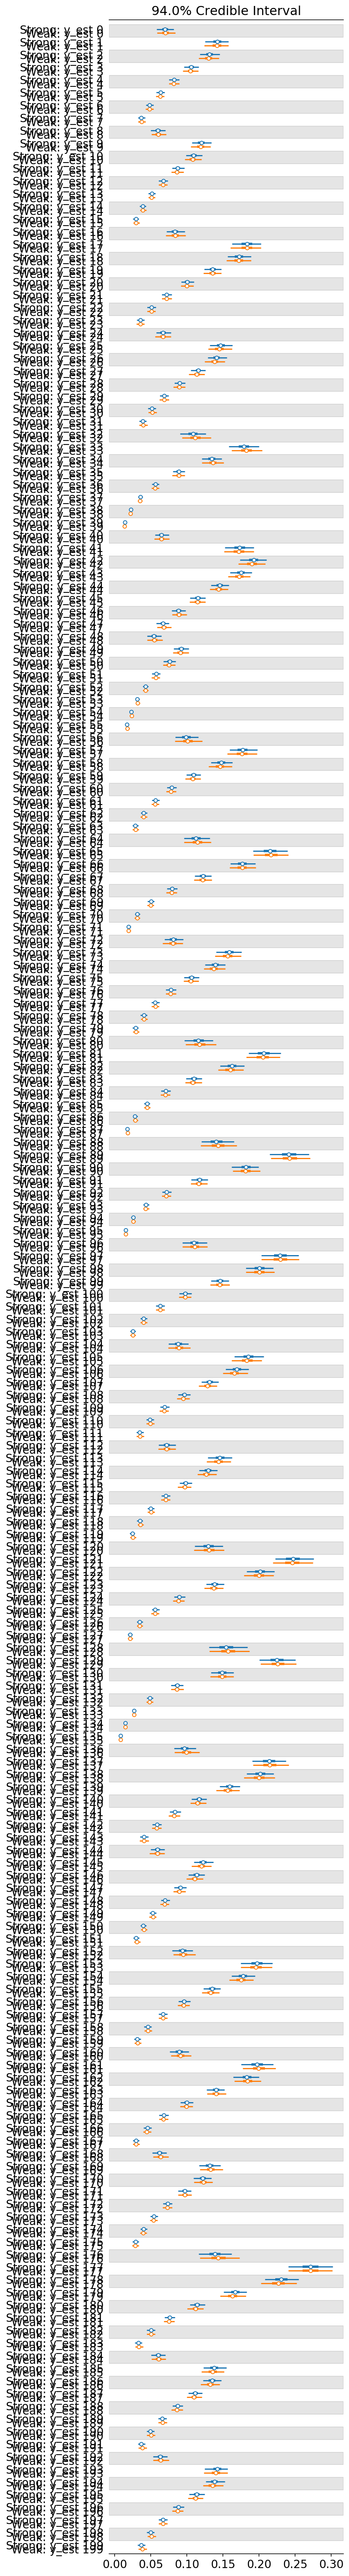

In [8]:
funcs={'posterior_mean':np.mean, 'ymin': lambda x: np.percentile(x, 2.5), 'ymax': lambda x: np.percentile(x,97.5)}

az.plot_forest(
    [strong_data, weak_data], 
    model_names=["Strong", "Weak"], 
    var_names=['y_est'],
    combined=True
)


Text(0, 0.5, 'Strong Model Predictions')

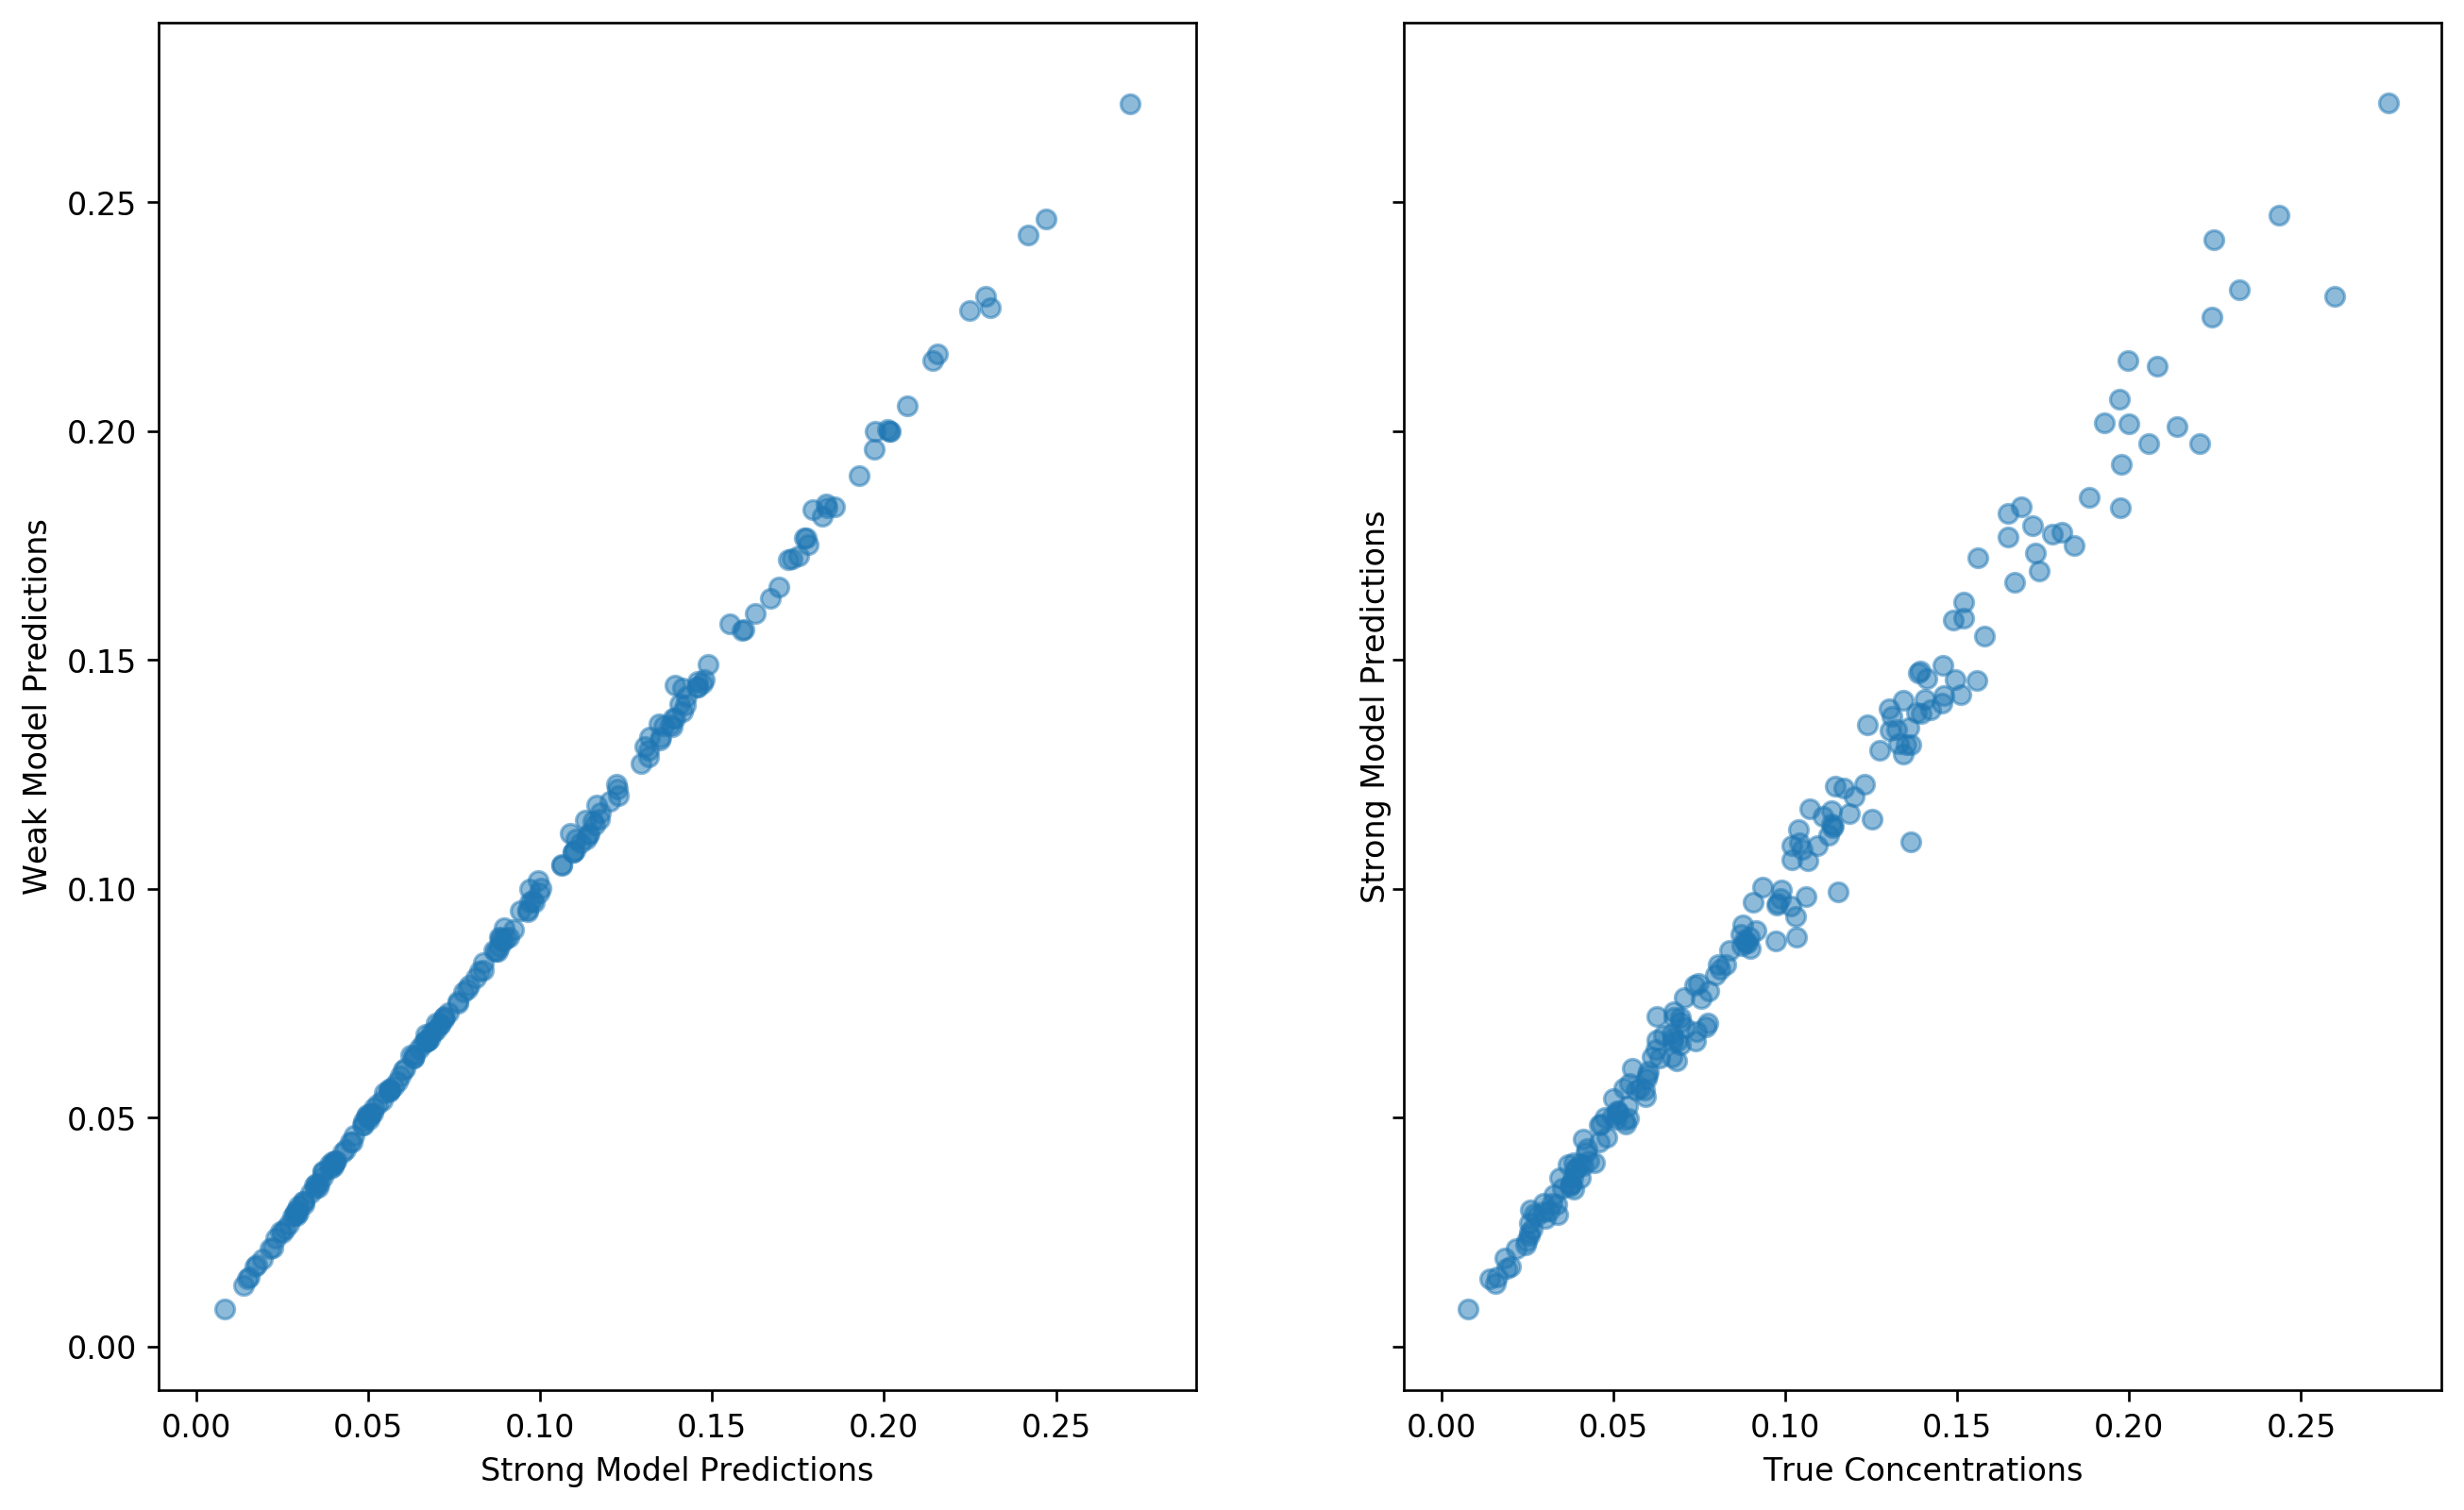

In [13]:
predictions = summarize_posterior(strong_data, 'y_est', 'pred')
ppc = summarize_ppc(strong_data,'Yobs','ppc')

strong_sum = df.join(predictions).join(ppc)

predictions = summarize_posterior(weak_data, 'y_est', 'pred')
ppc = summarize_ppc(weak_data,'Yobs','ppc')

weak_sum = df.join(predictions).join(ppc)




fig, ax = plt.subplots(dpi=120, ncols=2, figsize = (13,8), sharex = True, sharey=True)

ax = ax.ravel()

ax[0].scatter(strong_sum.pred_pred, weak_sum.pred_pred, alpha = 0.5)
ax[0].set_xlabel('Strong Model Predictions')
ax[0].set_ylabel('Weak Model Predictions')


ax[1].scatter(strong_sum.y, strong_sum.pred_pred, alpha = 0.5)
ax[1].set_xlabel('True Concentrations')
ax[1].set_ylabel('Strong Model Predictions')
